Step 1: Dataset Preprocessing Code

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


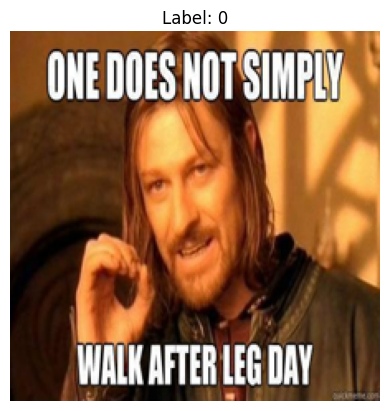

Text: How I feel today #legday #jelly #aching #gym
Label: 0
Image shape: (224, 224, 3)


In [2]:
import os
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Set dataset path
DATA_DIR = '/content/drive/MyDrive/MLAI/Multimodal sentiment analysis/MVSA_Single'
IMAGE_TEXT_DIR = os.path.join(DATA_DIR, 'data')
LABEL_FILE = os.path.join(DATA_DIR, 'label.txt')

# Load label file
df = pd.read_csv(LABEL_FILE, sep='\t')
df.columns = ['id', 'labels']

# Define sentiment map
sentiment_map = {'positive': 0, 'neutral': 1, 'negative': 2}

# Function to load a sample with safety checks
def load_sample(row):
    sample_id = str(row['id'])
    text_path = os.path.join(IMAGE_TEXT_DIR, sample_id + '.txt')
    image_path = os.path.join(IMAGE_TEXT_DIR, sample_id + '.jpg')

    # Check if both files exist
    if not os.path.isfile(text_path) or not os.path.isfile(image_path):
        return None

    try:
        with open(text_path, 'r', encoding='utf-8') as f:
            text = f.read().strip()

        image = Image.open(image_path).convert('RGB')
        image = image.resize((224, 224))  # For ResNet context feature
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.0

        label = row['labels'].split(',')  # text_label, image_label
        y = sentiment_map.get(label[1].strip().lower())  # using image sentiment

        return image, text, y
    except Exception as e:
        print(f"Skipping ID {sample_id} due to error: {e}")
        return None

# Load and filter clean samples
sample_data = []
for _, row in df.iterrows():
    result = load_sample(row)
    if result:
        sample_data.append(result)
    if len(sample_data) >= 5:
        break  # Load just 5 for now to test

# Show one example with image
if sample_data:
    img, txt, lbl = sample_data[0]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Label: {lbl}")
    plt.show()

    print(f"Text: {txt}")
    print(f"Label: {lbl}")
    print(f"Image shape: {img.shape}")
else:
    print("No valid samples found.")

Train Dataset

In [3]:
# import pandas as pd

# # Path to your labels file
# LABEL_PATH = '/content/drive/MyDrive/MLAI/Multimodal sentiment analysis/MVSA_Single/label.txt'

# # Load label file (tab separated)
# df = pd.read_csv(LABEL_PATH, sep="\t", names=["ID", "text_label,image_label"], header=None)

# # Optional: strip whitespace and split the sentiment values
# df[["text_label", "image_label"]] = df["text_label,image_label"].str.split(",", expand=True)

# # For now, use the majority of text and image labels (you can customize this)
# df["label"] = df.apply(lambda row: row["text_label"] if row["text_label"] == row["image_label"] else "neutral", axis=1)
# df.drop(columns=["text_label,image_label", "text_label", "image_label"], inplace=True)

# # Display a sample
# df.head()


In [4]:
# label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
# df["label_id"] = df["label"].map(label_map)


In [5]:
# import tensorflow as tf
# import os

# DATA_DIR = '/content/drive/MyDrive/MLAI/Multimodal sentiment analysis/MVSA_Single/data'

# # Convert dataframe to a list of (image_path, text_path, label_id)
# samples = []
# for _, row in df.iterrows():
#     sample_id = str(row["ID"])
#     image_path = os.path.join(DATA_DIR, sample_id + ".jpg")
#     text_path = os.path.join(DATA_DIR, sample_id + ".txt")
#     label = row["label_id"]

#     if os.path.exists(image_path) and os.path.exists(text_path):
#         samples.append((image_path, text_path, label))


In [6]:
# from transformers import BertTokenizer
# from PIL import Image
# import numpy as np

# # Load BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# # Image preprocessing function (resize to 224x224 and normalize)
# def preprocess_image(image_path):
#     image = Image.open(image_path).convert("RGB")
#     image = image.resize((224, 224))
#     image = np.array(image) / 255.0  # Normalize to [0, 1]
#     return image.astype(np.float32)

# # Text preprocessing using BERT tokenizer
# def preprocess_text(text_path):
#     with open(text_path, "r", encoding="utf-8") as f:
#         text = f.read().strip()
#     tokens = tokenizer(text, padding="max_length", truncation=True, max_length=32, return_tensors="tf")
#     return tokens["input_ids"][0], tokens["attention_mask"][0]


In [7]:
# def load_and_preprocess(image_path, text_path, label):
#     image = preprocess_image(image_path.numpy().decode())
#     input_ids, attention_mask = preprocess_text(text_path.numpy().decode())
#     return image, input_ids, attention_mask, label

# def tf_wrapper(image_path, text_path, label):
#     image, input_ids, attention_mask, label = tf.py_function(
#         load_and_preprocess, inp=[image_path, text_path, label],
#         Tout=[tf.float32, tf.int32, tf.int32, tf.int32]
#     )
#     image.set_shape([224, 224, 3])
#     input_ids.set_shape([32])
#     attention_mask.set_shape([32])
#     return (image, input_ids, attention_mask), tf.one_hot(label, depth=3)


In [8]:
# # Separate lists for TensorFlow compatibility
# image_paths = []
# text_paths = []
# labels = []

# for img_path, txt_path, label in samples:
#     image_paths.append(img_path)
#     text_paths.append(txt_path)
#     labels.append(label)

# # Create TensorFlow dataset from slices
# paths_ds = tf.data.Dataset.from_tensor_slices((image_paths, text_paths, labels))

# # Map preprocessing
# train_dataset = paths_ds.shuffle(buffer_size=len(labels)) \
#     .map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE) \
#     .batch(32) \
#     .prefetch(tf.data.AUTOTUNE)


Step 2: Text Embedding with BERT + BiGRU

In [9]:
!pip install transformers

In [10]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Set max token length (can tweak this)
MAX_LEN = 64
BERT_DIM = 768
GRU_UNITS = 256
D = 2 * GRU_UNITS  # Because Bi-GRU is used

# Function to tokenize a single sentence
def tokenize_text(text):
    encoded = tokenizer(text,
                        padding='max_length',
                        truncation=True,
                        max_length=MAX_LEN,
                        return_tensors='tf')
    return encoded['input_ids'], encoded['attention_mask']

# BERT + Bi-GRU model
class TextEncoder(tf.keras.Model):
    def __init__(self, gru_units=GRU_UNITS):
        super(TextEncoder, self).__init__()
        self.bert = bert_model
        self.bi_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
            gru_units, return_sequences=True))

    def call(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeddings = outputs.last_hidden_state  # Shape: (batch, seq_len, 768)

        gru_output = self.bi_gru(bert_embeddings)  # Shape: (batch, seq_len, 2*GRU_UNITS)
        word_features = tf.reduce_mean(gru_output, axis=-1)  # Averaged over forward/backward

        return gru_output, word_features  # word_features ∈ [batch, seq_len], word embeddings


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
# Pick one text sample from your loaded dataset
_, sample_text, _ = sample_data[0]
print("Sample:", sample_text)

# Tokenize
input_ids, attention_mask = tokenize_text(sample_text)
input_ids = tf.cast(input_ids, tf.int32)
attention_mask = tf.cast(attention_mask, tf.int32)

# Encode
text_encoder = TextEncoder()
word_embeddings, context_vector = text_encoder(input_ids, attention_mask)

print(f"Word Embeddings shape: {word_embeddings.shape}")
print(f"Context Vector shape: {context_vector.shape}")


Sample: How I feel today #legday #jelly #aching #gym
Word Embeddings shape: (1, 64, 512)
Context Vector shape: (1, 64)



Step 3: Extract Region Features (Offline)

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Simulate m regions with ResNet output (say we treat global feature as 1 region for demo)
m = 1  # Simulating 1 region per image for simplicity
region_feat_dim = 2048
projected_dim = 512

# Base ResNet model for feature extraction
base_model = ResNet50(include_top=False, pooling='avg', input_shape=(224, 224, 3))
# Freeze ResNet
base_model.trainable = False

# Projection layer to get ri from fi
region_projector = tf.keras.Sequential([
    tf.keras.layers.Dense(projected_dim, activation=None)  # Wrfi + br
])

def extract_region_feature(image_tensor):
    fi = base_model(tf.expand_dims(image_tensor, axis=0))  # (1, 2048)
    ri = region_projector(fi)  # (1, projected_dim)
    return tf.squeeze(ri, axis=0)  # (projected_dim,)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
sample_image, _, _ = sample_data[0]
region_feature = extract_region_feature(sample_image)

print("Extracted region feature shape:", region_feature.shape)  # Should be (512,)


Extracted region feature shape: (512,)


Step 4: Cross-Modal Alignment (Eq. 5–7)

In [14]:
import math

import tensorflow as tf
import math

class CrossModalAlignment(tf.keras.layers.Layer):
    def __init__(self, input_dim, align_dim):
        super(CrossModalAlignment, self).__init__()
        self.proj_region = tf.keras.layers.Dense(align_dim)
        self.proj_word = tf.keras.layers.Dense(align_dim)
        self.align_dim = align_dim

    def call(self, regions, words):
        """
        regions: [batch_size, m, d]
        words: [batch_size, n, d]
        """
        # Project to alignment space
        WrR = self.proj_region(regions)  # shape: (batch, m, k)
        WtW = self.proj_word(words)      # shape: (batch, n, k)

        # Affinity matrix A: [batch, m, n]
        A = tf.matmul(WrR, WtW, transpose_b=True)

        # Scaled softmax normalization over words
        A_bar = tf.nn.softmax(A / tf.math.sqrt(tf.cast(self.align_dim, tf.float32)), axis=-1)

        # Contextualized visual-text feature: U [batch, m, d]
        U = tf.matmul(A_bar, words)

        return U


In [15]:
# Simulate batch data
regions = tf.expand_dims(region_feature, axis=0)  # (1, 512)
regions = tf.expand_dims(regions, axis=1)         # (1, 1, 512)
words = word_embeddings  # From TextEncoder earlier (1, seq_len, 512)

# Make sure word embeddings and region features have same dim
word_proj = tf.keras.layers.Dense(projected_dim)
words_proj = word_proj(words)

cross_modal_align = CrossModalAlignment(input_dim=projected_dim, align_dim=128)
U = cross_modal_align(regions, words_proj)

print("Cross-modal interactive feature U shape:", U.shape)  # Should be (1, m, d)


Cross-modal interactive feature U shape: (1, 1, 512)


Step 5: Cross-Modal Gating Module


In [16]:
class CrossModalGating(tf.keras.layers.Layer):
    def __init__(self, input_dim, proj_dim):
        super(CrossModalGating, self).__init__()
        self.proj_regions = tf.keras.layers.Dense(proj_dim)
        self.proj_U = tf.keras.layers.Dense(proj_dim)

    def call(self, regions, U):
        # regions: (batch, m, input_dim)
        # U: (batch, m, proj_dim)
        proj_regions = self.proj_regions(regions)  # (batch, m, proj_dim)
        proj_U = self.proj_U(U)                    # (batch, m, proj_dim)

        gate_logits = tf.reduce_sum(proj_regions * proj_U, axis=-1, keepdims=True)  # (batch, m, 1)
        gates = tf.sigmoid(gate_logits)
        gated = gates * proj_regions + (1 - gates) * proj_U  # gated fusion
        output = tf.reduce_sum(gated, axis=1)  # sum over regions (m)
        return output


In [17]:
gating_module = CrossModalGating(input_dim=2048, proj_dim=512)

# U: [batch, m, d], regions: [batch, m, d]
C = gating_module(regions, U)  # output: [batch, d]
print("Final cross-modal representation C shape:", C.shape)


Final cross-modal representation C shape: (1, 512)


Define and Extract Visual Context V

Step 6: Context Feature Extraction

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

class VisualContextExtractor(tf.keras.Model):
    def __init__(self):
        super(VisualContextExtractor, self).__init__()
        base_model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
        self.feature_extractor = base_model  # output shape: [batch, 2048]

    def call(self, images):
        images = preprocess_input(images)  # required for ResNet
        V = self.feature_extractor(images)
        return V  # shape: [batch, 2048]


In [19]:
# Example word embeddings (e.g., from BERT or other word encoders)
word_embeddings = tf.random.normal([1, 10, 512])  # [batch, seq_len, embedding_dim]

def extract_textual_context(word_embeddings):
    """
    word_embeddings: [batch, n, d]
    returns sentence-level context S: [batch, d]
    """
    return tf.reduce_mean(word_embeddings, axis=1)  # average over words

S = extract_textual_context(word_embeddings)  # [1, 512]
print("Textual context S shape:", S.shape)


Textual context S shape: (1, 512)


Visual Context (V) shape: (1, 2048)


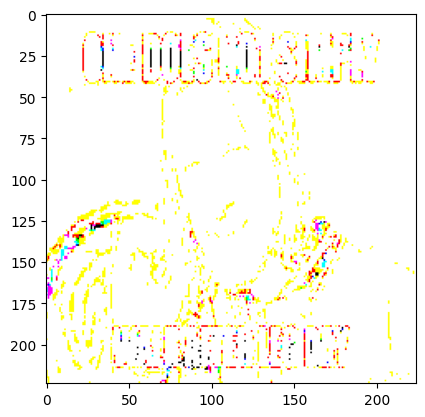

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

# Define the VisualContextExtractor class as before
class VisualContextExtractor(tf.keras.Model):
    def __init__(self):
        super(VisualContextExtractor, self).__init__()
        base_model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
        self.model = base_model

    def call(self, images):
        images = preprocess_input(images)  # required normalization
        features = self.model(images)      # shape: [batch, 2048]
        return features

# Image Preprocessing: Resize and Normalize
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to (224, 224)
    img_array = image.img_to_array(img)  # Convert to array
    img_array = tf.image.convert_image_dtype(img_array, dtype=tf.float32)  # Normalize to [0, 1]
    return img_array

# Load and preprocess an image sample from your dataset
image_path = "/content/drive/MyDrive/MLAI/Multimodal sentiment analysis/MVSA_Single/data/1.jpg"  # Adjust the path
processed_img = preprocess_image(image_path)

# Add batch dimension: [batch, 224, 224, 3]
processed_img = tf.expand_dims(processed_img, axis=0)

# Instantiate the visual context extractor
vc_extractor = VisualContextExtractor()

# Extract the visual context representation
V = vc_extractor(processed_img)  # Output: [1, 2048]
print("Visual Context (V) shape:", V.shape)

# Optional: Visualize the image
plt.imshow(processed_img[0])
plt.show()


In [21]:
class ContextIntegrator(tf.keras.Model):
    def __init__(self, hidden_dim, λ=0.5):
        super(ContextIntegrator, self).__init__()
        self.mlp1 = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim, activation='relu'),
            tf.keras.layers.Dense(hidden_dim)
        ])
        self.mlp2 = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim, activation='relu'),
            tf.keras.layers.Dense(hidden_dim)
        ])
        self.λ = λ

    def call(self, V, S, C):
      """
      V: visual context [batch, v_dim]
      S: text context [batch, d]
      C: cross-modal feature [batch, d]  # Already no extra dim
      """
      # Remove this line:
      # C = tf.squeeze(C, axis=1)

      F1 = self.mlp1(tf.concat([V, C], axis=-1))
      F2 = self.mlp2(tf.concat([S, C], axis=-1))
      F = self.λ * F1 + (1 - self.λ) * F2
      return F  # [batch, hidden_dim]


context_integrator = ContextIntegrator(hidden_dim=512, λ=0.6)
F = context_integrator(V, S, C)
print("Final multimodal feature F shape:", F.shape)

Final multimodal feature F shape: (1, 512)


Something...

Step 7: Multimodal Sentiment Classification

In [22]:
class SentimentClassifier(tf.keras.Model):
    def __init__(self, input_dim, num_classes=3):
        super(SentimentClassifier, self).__init__()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(num_classes)  # 3 classes: Positive, Neutral, Negative
        self.softmax = tf.keras.layers.Softmax()

    def call(self, F):
        x = self.dense1(F)
        logits = self.dense2(x)
        return self.softmax(logits)  # Predicted sentiment probabilities


In [23]:
def compute_loss(y_true, y_pred):
    """
    y_true: Ground truth labels (one-hot encoded) - [batch_size, num_classes]
    y_pred: Predictions from the softmax classifier - [batch_size, num_classes]
    """
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))
    return cross_entropy_loss


In [24]:
# @tf.function
# def train_step(model, images, input_ids, attention_masks, labels):
#     with tf.GradientTape() as tape:
#         # Step 1: Visual Context (ResNet18)
#         visual_context = visual_context_extractor(images)  # (B, 512)

#         # Step 2: Textual features (BERT + BiGRU)
#         bert_outputs = bert_model(input_ids, attention_mask=attention_masks)
#         bert_embeddings = bert_outputs.last_hidden_state  # (B, seq_len, 768)
#         word_features = text_gru(bert_embeddings)  # (B, seq_len, 512)

#         # Step 3: Cross-modal alignment
#         alignment_features = cross_modal_alignment(visual_context, word_features)  # (B, num_regions, align_dim)

#         # Step 4: Cross-modal gating
#         gated_features = cross_modal_gating(visual_context, alignment_features)  # (B, num_regions, align_dim)

#         # Step 5: Aggregated representation
#         fused_feature = context_integrator(visual_context, word_features, gated_features)  # (B, 512)

#         # Step 6: Classification
#         logits = model(fused_feature)
#         loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))

#     grads = tape.gradient(loss, model.trainable_variables +
#                                 visual_context_extractor.trainable_variables +
#                                 cross_modal_alignment.trainable_variables +
#                                 cross_modal_gating.trainable_variables +
#                                 context_integrator.trainable_variables)
#     optimizer.apply_gradients(zip(grads, model.trainable_variables +
#                                         visual_context_extractor.trainable_variables +
#                                         cross_modal_alignment.trainable_variables +
#                                         cross_modal_gating.trainable_variables +
#                                         context_integrator.trainable_variables))
#     return loss

In [25]:
import os
import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path setup
BASE_DIR = '/content/drive/MyDrive/MLAI/Multimodal sentiment analysis/MVSA_Single'
DATA_DIR = os.path.join(BASE_DIR, 'data')
LABEL_FILE = os.path.join(BASE_DIR, 'label.txt')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Read label.txt
df = pd.read_csv(LABEL_FILE, sep='\t', header=None, names=['ID', 'Sentiments'])

# Drop rows with NaNs or bad format
df = df.dropna()

# Split into text and image sentiments
df[['text_sentiment', 'image_sentiment']] = df['Sentiments'].str.split(',', expand=True)


In [38]:
sentiment_to_label = {'positive': 0, 'neutral': 1, 'negative': 2}

def load_image(image_path):
    import tensorflow as tf
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img

def load_data_point(row):
    sample_id = str(row['ID'])

    text_file = os.path.join(DATA_DIR, sample_id + '.txt')
    image_file = os.path.join(DATA_DIR, sample_id + '.jpg')

    if not (os.path.exists(text_file) and os.path.exists(image_file)):
        return None

    try:
        with open(text_file, 'r', errors='ignore') as f:
            text = f.read().strip()
    except:
        return None

    label_str = row['text_sentiment'].strip().lower()
    label = sentiment_to_label.get(label_str)
    if label is None:
        return None

    return (image_file, text, label)

valid_rows = [load_data_point(row) for _, row in df.iterrows()]
valid_rows = [r for r in valid_rows if r is not None]
print(f"Total valid samples: {len(valid_rows)}")


Total valid samples: 812


In [39]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_text(text):
    tokens = tokenizer(text, padding='max_length', truncation=True, max_length=30, return_tensors='tf')
    return tokens['input_ids'][0], tokens['attention_mask'][0]

encoded_data = []
for image_path, text, label in valid_rows:
    input_ids, attention_mask = encode_text(text)
    encoded_data.append((image_path, input_ids, attention_mask, label))


In [40]:
import tensorflow as tf

NUM_CLASSES = 3

def data_generator(data, batch_size=32):
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        image_paths, input_ids, attention_masks, labels = zip(*batch)

        images = tf.stack([load_image(p) for p in image_paths])
        input_ids = tf.stack(input_ids)
        attention_masks = tf.stack(attention_masks)
        labels = tf.one_hot(labels, depth=NUM_CLASSES)

        yield (images, input_ids, attention_masks, labels)

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(encoded_data),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 30), dtype=tf.int32),
        tf.TensorSpec(shape=(None, 30), dtype=tf.int32),
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
    )
)


In [41]:
for batch in train_dataset.take(1):
    images, input_ids, attention_masks, labels = batch
    print("Image batch shape:", images.shape)
    print("Text input_ids shape:", input_ids.shape)
    print("Attention mask shape:", attention_masks.shape)
    print("Labels shape:", labels.shape)


Image batch shape: (32, 224, 224, 3)
Text input_ids shape: (32, 30)
Attention mask shape: (32, 30)
Labels shape: (32, 3)


In [42]:
from transformers import TFBertModel

# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define BiGRU layer
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=False))


visual_projection_layer = tf.keras.layers.Dense(512, activation='relu')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [43]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_CLASSES = 3  # Positive, Neutral, Negative
NUM_REGIONS = 10

# 1. Model components
visual_context_extractor = VisualContextExtractor()
cross_modal_alignment = CrossModalAlignment(input_dim=512, align_dim=128)
cross_modal_gating = CrossModalGating(input_dim=128, proj_dim=512)  # example proj_dim
context_integrator = ContextIntegrator(hidden_dim=512, λ=0.6)
sentiment_classifier = SentimentClassifier(input_dim=512, num_classes=NUM_CLASSES)

# 2. Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# 3. Training Step Function
@tf.function
def train_step(images, input_ids, attention_masks, labels):
    with tf.GradientTape() as tape:
        # Visual features from CNN (B, m, d)
        visual_features = visual_context_extractor(images)

        # Text features from BERT → BiGRU (B, d)
        bert_output = bert_model(input_ids, attention_mask=attention_masks)[0]
        text_features = bigru(bert_output)

        # Expand text to match region count (NUM_REGIONS)
        text_expanded = tf.expand_dims(text_features, 1)
        text_expanded = tf.repeat(text_expanded, repeats=NUM_REGIONS, axis=1)

        # Cross-modal alignment (returns aligned features, shape B, m, d)
        aligned_features = cross_modal_alignment(visual_features, text_expanded)

        # Cross-modal gating (shape B, d)
        gated_features = cross_modal_gating(visual_features, aligned_features)

        # Aggregate visual features for visual context (shape B, d)
        # Visual features shape check:
        print("visual_features shape:", visual_features.shape)  # for debugging

        # Assume visual_features is (batch, d) already
        visual_features = visual_context_extractor(images)  # shape: (B, 2048)
        visual_features_proj = visual_projection_layer(visual_features)  # Dense layer projecting 2048 → 512

        # text_features is (B, 512)
        # gated_features is (B, 512)
        # Text context (batch, d)
        text_context = text_features

        # Cross-modal gated feature (batch, d)
        cross_modal_feature = gated_features

        context = context_integrator(visual_features_proj, text_features, gated_features)





        #context = context_integrator(visual_context, text_context, cross_modal_feature)


        # Final classification
        logits = sentiment_classifier(context)

        loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(labels, logits))

    # Compute gradients
    gradients = tape.gradient(loss, sentiment_classifier.trainable_variables +
                                     visual_context_extractor.trainable_variables +
                                     cross_modal_alignment.trainable_variables +
                                     cross_modal_gating.trainable_variables +
                                     context_integrator.trainable_variables +
                                     bigru.trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, sentiment_classifier.trainable_variables +
                                             visual_context_extractor.trainable_variables +
                                             cross_modal_alignment.trainable_variables +
                                             cross_modal_gating.trainable_variables +
                                             context_integrator.trainable_variables +
                                             bigru.trainable_variables))
    return loss

# 4. Training Loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    total_loss = 0.0
    steps = 0

    for batch in train_dataset:
        images, input_ids, attention_masks, labels = batch
        loss = train_step(images, input_ids, attention_masks, labels)
        total_loss += loss.numpy()
        steps += 1

    avg_loss = total_loss / steps if steps > 0 else 0.0
    print(f"Loss: {avg_loss:.4f}")



Epoch 1/10
visual_features shape: (32, 2048)
visual_features shape: (32, 2048)


KeyboardInterrupt: 